# **POS Tagging**

# PART 1

## Installs, Imports and Paths

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!pip install scikit_learn
!pip install nltk
!pip install --upgrade wandb
!pip install datasets
!pip install tensorflow
!pip install scipy
!pip install scikeras
!pip install numpy
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b93ff03b3d71afa432949379bef85c06e9113b3dfabc8090de2255e671559c8f
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be00

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import pickle
import random
import nltk
import wandb
import os
import string
import spacy
import keras
import urllib.request, zipfile
from collections import Counter
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.constraints import MaxNorm
from sklearn import preprocessing
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import FastText
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from nltk import sent_tokenize, word_tokenize, pos_tag
from pandas.core.missing import find_valid_index
from sklearn.model_selection import learning_curve, GridSearchCV
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
stemmer = WordNetLemmatizer()

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [ ]:
if not os.path.exists('./POS-Tagging'):
  os.makedirs('./POS-Tagging')
os.chdir('./POS-Tagging')
uploaded = files.upload()

Saving en_lines-ud-dev.txt to en_lines-ud-dev.txt
Saving en_lines-ud-test.txt to en_lines-ud-test.txt
Saving en_lines-ud-train.txt to en_lines-ud-train.txt


## Data Preprocessing

In [ ]:
def myData(name, percentage):
  with open(name, "r") as myfile:
    my_data = myfile.read()
    cropped_data = my_data[:int(len(my_data)*percentage)]

  return cropped_data


train_data = myData("en_lines-ud-train.txt", 1) # as a second parameter pass the percentage of the data you want
dev_data = myData("en_lines-ud-dev.txt", 1)
test_data = myData("en_lines-ud-test.txt", 1)

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('sentencizer')

# tokenize and lemmatize the data and finally create x-y list
def processing(my_data):
  
  tuples=[]
  x = []
  y = []
  for sent in my_data.sents:
    partial_tuple=[]
    temp_x = []
    temp_y = []
    for token in sent:
      if token.pos_:
        temp_x.append(token.lemma_)
        temp_y.append(token.pos_)
        partial_tuple.append((token.lemma_, token.pos_))
    tuples.append(partial_tuple)
    x.append(temp_x)
    y.append(temp_y)
  return tuples, x, y

train_tuples, x_train, y_train = processing(nlp(train_data))
dev_tuples, x_dev, y_dev = processing(nlp(dev_data))
test_tuples, x_test, y_test = processing(nlp(test_data))

## Loading Pre-trained Embeddings

In [ ]:
if not os.path.exists('./embeddings'):
  os.makedirs('./embeddings')

urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', './embeddings/wiki-news-300d-1M.vec.zip')
zip_ref = zipfile.ZipFile('./embeddings/wiki-news-300d-1M.vec.zip', 'r')
zip_ref.extractall('./embeddings')
zip_ref.close()

embs_path = './embeddings/wiki-news-300d-1M.vec'
embeddings = KeyedVectors.load_word2vec_format(embs_path, binary=False)

## Data Manipulation

In [ ]:
dim = embeddings.vectors.shape[1] # the width of the E matrix
pad = np.zeros(dim) # Pad vector
np.random.seed(3) # For reproducibility 
oov =  np.random.uniform(-0.25, 0.25, dim) # Out-of-vocabulary vector, assign relatively small values

def features_embs(sentence, index, window=1):
    """ sentence: [w1, w2, ...],
        index: the index of the word, 
        window: number of places left and right of the classified word """
    unknown = 0
    vec = np.array([]) # define the vector
    for i in range(index-window,index+window+1):
        if i<0 or i>(len(sentence)-1):
            vec = np.append(vec, pad) # for word indices out of sentence bounds, append pad vector which contains only zeros 
            continue
        try:
            vec = np.append(vec, embeddings[sentence[i]]) # if you found the correct pre-trained embedding assign the corresponding values
        except:
            vec = np.append(vec, oov) #if word is not in embedding model append the out-of-vocabulary vector
            unknown +=1 # count the total words of the sentence that were out-of-vocabulary
                
    return vec, unknown

In [ ]:
def features_basic(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'nb_terms': len(sentence),        
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'i-1_prefix-3': '' if index == 0 else sentence[index-1][:3],        
        'i-1_suffix-3': '' if index == 0 else sentence[index-1][-3:],
        'i+1_prefix-3': '' if index == len(sentence) - 1 else sentence[index+1][:3],        
        'i+1_suffix-3': '' if index == len(sentence) - 1 else sentence[index+1][-3:],        
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:],
    }

In [ ]:
def transform_to_dataset(tuples, x, y, window):
    i=0
    count = 0
    temp_x, temp_y = [], []
    for sent_index, tagged in enumerate(tuples):
        for index in range(len(tagged)):
            temp_x.append([features_embs(x[count], index, window)[0], features_basic(x[count], index)])
            temp_y.append(tagged[index][1])
            k = features_embs(x[count], index, window)[1]
            i += k
        count += 1
    return temp_x, temp_y, i

In [ ]:
def vectorize(train_tuples, train_x, train_y, dev_tuples, dev_x, dev_y,  test_tuples, test_x, test_y, window=1):
              
    x_train, y_train, unk_train = transform_to_dataset(train_tuples, train_x, train_y, window=window)
    x_train = [x[0] for x in x_train]
    x_train = np.asarray(x_train)

    x_dev, y_dev, unk_dev = transform_to_dataset(dev_tuples, dev_x, dev_y, window=window)
    x_dev = [x[0] for x in x_dev]
    x_dev = np.asarray(x_dev)        
        
    x_test, y_test, unk_test = transform_to_dataset(test_tuples, test_x, test_y, window=window)
    x_test = [x[0] for x in x_test]
    x_test = np.asarray(x_test)
        
    print('Train shape:', x_train.shape)
    print('Validation shape:', x_dev.shape)
    print('Test shape:', x_test.shape)
    print('Found %s unknown words in train set %s unknown words in validation set and %s unknown words in test set' % (unk_train, unk_dev, unk_test))
    return x_train, y_train, x_dev, y_dev, x_test, y_test

In [ ]:
x_train_mod, y_train_mod, x_dev_mod, y_dev_mod, x_test_mod, y_test_mod = vectorize(train_tuples, x_train, y_train, 
                                                                dev_tuples, x_dev,
                                                                y_dev,test_tuples, x_test, y_test, window=1)

Train shape: (61578, 900)
Validation shape: (20650, 900)
Test shape: (19028, 900)
Found 11214 unknown words in train set 3814 unknown words in validation set and 3466 unknown words in test set


In [ ]:
classes = ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'VERB', 'X']

le = preprocessing.LabelEncoder()

y_train_lb = le.fit_transform(y_train_mod)
y_dev_lb = le.transform(y_dev_mod)
y_test_lb = le.transform(y_test_mod)

y_train_cat = keras.utils.to_categorical(y_train_lb)
y_dev_cat = keras.utils.to_categorical(y_dev_lb)
y_test_cat = keras.utils.to_categorical(y_test_lb)

print(np.unique(y_train_lb))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


## Baseline

In [ ]:
def dummyClassifier(x, y): # {'is' : {'verb': 3, 'noun': 4}, 'hi' : {'adjective': 6}}
  my_dict = {}
  unk_count = {}
  count_sents = 0
  for sent in x: # for every sentence in sentences
    count_words = 0
    for word in sent: # for every word in a sentence
      temp_dict = {} 
      if word in my_dict.keys(): # if the word has been encountered again

        if y[count_sents][count_words] in my_dict[word]: # if the tag has been encountered again
          temp_dict = my_dict[word]
          sum = temp_dict.get(y[count_sents][count_words]) + 1 # add 1 to the sum of the tag
          temp_dict.update({y[count_sents][count_words]: sum})  
          my_dict.update({word: temp_dict}) # add to the big dictionary the new sub-dict
          sum2 = unk_count.get(y[count_sents][count_words]) + 1 # {'verb' = 3000 + 1}
          unk_count.update({y[count_sents][count_words]: sum2})
        else:
          temp_dict = my_dict[word] # {'verb' : 4}
          temp_dict[y[count_sents][count_words]] = 1 # { 'verb': 4, 'noun' = 1}
          my_dict[word] = temp_dict
          if y[count_sents][count_words] in unk_count:
            sum2 = unk_count.get(y[count_sents][count_words]) + 1 # {'verb' = 3000 + 1}
            unk_count.update({y[count_sents][count_words]: sum2})
          else:
            unk_count.update({y[count_sents][count_words]: 1})
      else:
        my_dict[word] = {y[count_sents][count_words]: 1}
        if y[count_sents][count_words] in unk_count:
          sum = unk_count.get(y[count_sents][count_words]) + 1 # {'verb' = 3000 + 1}
          unk_count.update({y[count_sents][count_words]: sum})
        else:
          unk_count.update({y[count_sents][count_words]: 1})
      count_words += 1
    count_sents += 1

  return my_dict, unk_count

In [ ]:
def classify(x, y):
  clas = []
  pred_y = []
  count_sents = 0
  for sent in x:
    count_words = 0
    sentences = []
    for word in sent:
      if word in baseline:
        sum = 0
        for tag in baseline[word]:
          if sum < baseline[word].get(tag):
            sum = baseline[word].get(tag)
            max = tag
        sentences.append((word, max))
        pred_y.append(max)
      else:
        sum = 0
        for tag in unknown:
          if sum < unknown.get(tag):
            sum = unknown.get(tag)
            max = tag
        sentences.append((word,max))
        pred_y.append(max)
      count_words += 1
    clas.append(sentences)
    count_sents += 1

  return clas, pred_y

In [ ]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline, unknown = dummyClassifier(x_train, y_train)

# Evaluate
train_predictions, pred_train_y = classify(x_train, y_train)
dummy_score = f1_score(y_train_mod, pred_train_y, average='macro')
print("Train f1-score: {:.2f}%".format(dummy_score*100))

dev_predictions, pred_dev_y = classify(x_dev, y_dev)
dummy_score = f1_score(y_dev_mod, pred_dev_y, average='macro')
print("Evaluation f1-score: {:.2f}% \n".format(dummy_score*100))

test_predictions, pred_test_y = classify(x_test, y_test)
dummy_score = f1_score(y_test_mod, pred_test_y, average='macro')
print("Test f1-score: {:.2f}% \n".format(dummy_score*100))

Train f1-score: 88.37%
Evaluation f1-score: 81.41% 

Test f1-score: 76.95% 



## MLP

In [ ]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        
        _val_f1 = f1_score(val_targ, val_predict,average='micro')
        _val_recall = recall_score(val_targ, val_predict,average='micro')
        _val_precision = precision_score(val_targ, val_predict,average='micro')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [ ]:
with tf.device('/device:GPU:0'):
  mlp_model = Sequential()
  mlp_model.add(Dense(512, input_dim=x_train_mod.shape[1] , activation='relu', kernel_constraint=MaxNorm(3.0)))
  mlp_model.add(Dropout(0.5))
  mlp_model.add(Dense(256,  activation='relu', kernel_constraint=MaxNorm(2.0)))
  mlp_model.add(Dropout(0.5))
  mlp_model.add(Dense(y_train_cat.shape[1], activation='softmax'))

  print(mlp_model.summary())
  
  #Configures the model for training.
  #CategoricalCrossentropy: Computes the crossentropy loss between the labels and predictions.
  mlp_model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(learning_rate=0.001),
      metrics=["accuracy"]
      )

  if not os.path.exists('./my_MLP_checkpoint'):
    os.makedirs('./my_MLP_checkpoint')

  # Callback to save the Keras model or model weights at some frequency.  
  checkpoint = ModelCheckpoint(
      './my_MLP_checkpoint/weights.hdf5',
      monitor='val_accuracy', 
      mode='max', 
      verbose=2,
      save_best_only=True,
      save_weights_only=True
      )
  

  history = mlp_model.fit(
      x_train_mod, 
      y_train_cat,
      validation_data=(x_dev_mod, y_dev_cat),
      batch_size=64,
      epochs=15,
      shuffle=True,
      callbacks=[Metrics(valid_data=(x_dev_mod, y_dev_cat)), checkpoint]
      )

  print(f"Test Accuracy: {mlp_model.evaluate(x_test_mod, y_test_cat)[1]:.5f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               461312    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 18)                4626      
                                                                 
Total params: 597,266
Trainable params: 597,266
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
646/646 [=========================

### Learning Curves

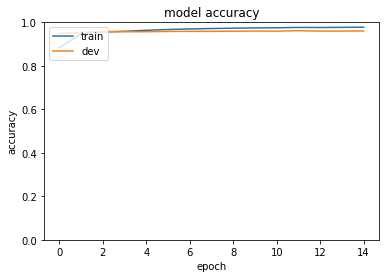

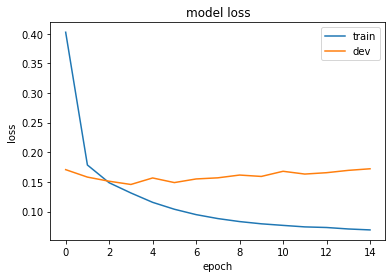

In [ ]:
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.ylim(0,1)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

### Model Assessment

In [ ]:
with tf.device('/device:GPU:0'):

  mlp_model = Sequential()
  mlp_model.add(Dense(512, input_dim=x_train_mod.shape[1], activation='relu'))
  mlp_model.add(Dense(256,  activation='relu'))
  mlp_model.add(Dense(y_train_cat.shape[1],  activation='softmax'))
  
  # Load weights from the pre-trained model
  mlp_model.load_weights("./my_MLP_checkpoint/weights.hdf5")
  mlp_model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(learning_rate=0.001),
      metrics=["accuracy"]
      )

yhat_probs = mlp_model.predict(x_train_mod, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
m_train_f1_score = f1_score(y_train_lb, yhat_classes, average = 'macro')
print("Train f1-score: {:.2f}% \n".format(m_train_f1_score*100))

yhat_probs = mlp_model.predict(x_dev_mod, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
m_dev_f1_score = f1_score(y_dev_lb, yhat_classes, average = 'macro')
print("Evaluation f1-score: {:.2f}% \n".format(m_dev_f1_score*100))

yhat_probs = mlp_model.predict(x_test_mod, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
m_test_f1_score = f1_score(y_test_lb, yhat_classes, average = 'macro')
print("Test f1-score: {:.2f}% \n".format(m_test_f1_score*100))

Train f1-score: 91.52% 

Evaluation f1-score: 84.61% 

Test f1-score: 84.42% 



### Precision, Recall, AUC, ROC-AUC

In [ ]:
def errorCheck(y_true, y_pred):

  # Find the unique classes in y_true and y_pred
  unique_classes = np.unique(np.concatenate((y_true, y_pred)))

  # Find the classes present in y_true but not in y_pred
  missing_classes_y_pred = unique_classes[np.in1d(unique_classes, y_true) & ~np.in1d(unique_classes, y_pred)]

  # Find the classes present in y_pred but not in y_true
  missing_classes_y_true = unique_classes[np.in1d(unique_classes, y_pred) & ~np.in1d(unique_classes, y_true)]

  # Calculate the sample size before modifying y_pred and y_true and my_max to know which has the extra class
  if len(y_pred) > len(y_true):
    my_max = y_pred
  else:
    my_max = y_true

  sample_size = max(len(y_pred), len(y_true))

  # Modify y_pred to include all the classes present in y_true
  for c in missing_classes_y_pred:
      y_pred = np.append(y_pred, c)

  # Modify y_true to include all the classes present in y_pred
  for c in missing_classes_y_true:
      y_true = np.append(y_true, c)

  y_pred_onehot = np.eye(len(unique_classes))[y_pred[:sample_size]]
  y_true_onehot = np.eye(len(unique_classes))[y_true[:sample_size]]


  return y_true, y_true_onehot, y_pred, y_pred_onehot, my_max

In [ ]:
def calculateResults(x, y_true, y_pred):
  # calculate precision, recall and f1
  train_precision_score = precision_score(y_true, y_pred, average=None)
  train_recall_score = recall_score(y_true, y_pred, average=None)
  train_f1_score = f1_score(y_true, y_pred, average=None)

  # macro precision, recall, f1 and auc
  m_train_precision_score = precision_score(y_true, y_pred, average='macro')

  m_train_recall_score = recall_score(y_true, y_pred, average='macro')

  m_train_f1_score = f1_score(y_true, y_pred, average='macro')

  # Error checking
  unique_pred = np.unique(y_pred)
  unique_true = np.unique(y_true)

  if unique_pred.shape != unique_true.shape:
      y_true_upd, y_true_onehot, y_pred_upd, y_pred_onehot, my_max = errorCheck(y_true, y_pred)

  elif unique_pred.shape == unique_true.shape & (unique_pred != unique_true).all():
      y_true_upd, y_true_onehot, y_pred_upd, y_pred_onehot, my_max = errorCheck(y_true, y_pred)

  else:
    my_max = y_pred # y_pred or y_true is the same thing in this case
    # One-hot encode the predicted class labels
    y_pred_onehot = np.eye(len(np.unique(y_pred)))[y_pred]

    # One-hot encode the true class labels
    y_true_onehot = np.eye(len(np.unique(y_true)))[y_true]

  m_train_roc_auc_score = roc_auc_score(y_true_onehot, y_pred_onehot, multi_class='ovr', average='macro')

  # auc calculation is a bit more messy

  classes = np.unique(my_max) # get the classes of the model
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x) # convert list to a dataframe
      y_proba = y_pred_onehot # calculate the probabilities
      df_aux = df_x.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y_true]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

  # Create and print the table
  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
           ['ADJ', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
           ['ADP', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
           ['ADV', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
           ['AUX', round(train_precision_score[3], 3), round(train_recall_score[3], 3), round(train_f1_score[3], 3), round(train_roc_auc_score[3], 3), '-', '-', '-', '-'],
           ['CCONJ', round(train_precision_score[4], 3), round(train_recall_score[4], 3), round(train_f1_score[4], 3), round(train_roc_auc_score[4], 3), '-', '-', '-', '-'],
           ['DET', round(train_precision_score[5], 3), round(train_recall_score[5], 3), round(train_f1_score[5], 3), round(train_roc_auc_score[5], 3), '-', '-', '-', '-'],
           ['INTJ', round(train_precision_score[6], 3), round(train_recall_score[6], 3), round(train_f1_score[6], 3), round(train_roc_auc_score[6], 3), '-', '-', '-', '-'],
           ['NOUN', round(train_precision_score[7], 3), round(train_recall_score[7], 3), round(train_f1_score[7], 3), round(train_roc_auc_score[7], 3), '-', '-', '-', '-'],
           ['NUM', round(train_precision_score[8], 3), round(train_recall_score[8], 3), round(train_f1_score[8], 3), round(train_roc_auc_score[8], 3), '-', '-', '-', '-'],
           ['PART', round(train_precision_score[9], 3), round(train_recall_score[9], 3), round(train_f1_score[9], 3), round(train_roc_auc_score[9], 3), '-', '-', '-', '-'],
           ['PRON', round(train_precision_score[10], 3), round(train_recall_score[10], 3), round(train_f1_score[10], 3), round(train_roc_auc_score[10], 3), '-', '-', '-', '-'],
           ['PROPN', round(train_precision_score[11], 3), round(train_recall_score[11], 3), round(train_f1_score[11], 3), round(train_roc_auc_score[11], 3), '-', '-', '-', '-'],
           ['PUNCT', round(train_precision_score[12], 3), round(train_recall_score[12], 3), round(train_f1_score[12], 3), round(train_roc_auc_score[12], 3), '-', '-', '-', '-'],
           ['SCONJ', round(train_precision_score[13], 3), round(train_recall_score[13], 3), round(train_f1_score[13], 3), round(train_roc_auc_score[13], 3), '-', '-', '-', '-'],
           ['SPACE', round(train_precision_score[14], 3), round(train_recall_score[14], 3), round(train_f1_score[14], 3), round(train_roc_auc_score[14], 3), '-', '-', '-', '-'],
           ['SYM', round(train_precision_score[15], 3), round(train_recall_score[15], 3), round(train_f1_score[15], 3), round(train_roc_auc_score[15], 3), '-', '-', '-', '-'],
           ['VERB', round(train_precision_score[16], 3), round(train_recall_score[16], 3), round(train_f1_score[16], 3), round(train_roc_auc_score[16], 3), '-', '-', '-', '-'],
           ['X', round(train_precision_score[17], 3), round(train_recall_score[17], 3), round(train_f1_score[17], 3), round(train_roc_auc_score[17], 3), '-', '-', '-', '-'],
           ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]


  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
  return table

In [ ]:
def calculateFinalResults(x, y):
  # predict probabilities for test set
  yhat_probs = mlp_model.predict(x, verbose=0)
  # predict crisp classes for test set
  yhat_classes = np.argmax(yhat_probs, axis=1)


  train_precision_score = precision_score(y, yhat_classes, average = None)
  train_recall_score = recall_score(y, yhat_classes, average = None)
  train_f1_score = f1_score(y, yhat_classes, average = None)


  m_train_precision_score = precision_score(y, yhat_classes, average = 'macro')
  m_train_recall_score = recall_score(y, yhat_classes, average = 'macro')
  m_train_f1_score = f1_score(y, yhat_classes, average = 'macro')


  m_train_roc_auc_score = roc_auc_score(y, yhat_probs, multi_class= 'ovr', average = 'macro')

  classes = np.unique(y)
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
    
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x) # convert list to a dataframe
      y_proba = mlp_model.predict(x, verbose=0) # calculate the probabilities
      df_aux = df_x.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
           ['ADJ', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
           ['ADP', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
           ['ADV', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
           ['AUX', round(train_precision_score[3], 3), round(train_recall_score[3], 3), round(train_f1_score[3], 3), round(train_roc_auc_score[3], 3), '-', '-', '-', '-'],
           ['CCONJ', round(train_precision_score[4], 3), round(train_recall_score[4], 3), round(train_f1_score[4], 3), round(train_roc_auc_score[4], 3), '-', '-', '-', '-'],
           ['DET', round(train_precision_score[5], 3), round(train_recall_score[5], 3), round(train_f1_score[5], 3), round(train_roc_auc_score[5], 3), '-', '-', '-', '-'],
           ['INTJ', round(train_precision_score[6], 3), round(train_recall_score[6], 3), round(train_f1_score[6], 3), round(train_roc_auc_score[6], 3), '-', '-', '-', '-'],
           ['NOUN', round(train_precision_score[7], 3), round(train_recall_score[7], 3), round(train_f1_score[7], 3), round(train_roc_auc_score[7], 3), '-', '-', '-', '-'],
           ['NUM', round(train_precision_score[8], 3), round(train_recall_score[8], 3), round(train_f1_score[8], 3), round(train_roc_auc_score[8], 3), '-', '-', '-', '-'],
           ['PART', round(train_precision_score[9], 3), round(train_recall_score[9], 3), round(train_f1_score[9], 3), round(train_roc_auc_score[9], 3), '-', '-', '-', '-'],
           ['PRON', round(train_precision_score[10], 3), round(train_recall_score[10], 3), round(train_f1_score[10], 3), round(train_roc_auc_score[10], 3), '-', '-', '-', '-'],
           ['PROPN', round(train_precision_score[11], 3), round(train_recall_score[11], 3), round(train_f1_score[11], 3), round(train_roc_auc_score[11], 3), '-', '-', '-', '-'],
           ['PUNCT', round(train_precision_score[12], 3), round(train_recall_score[12], 3), round(train_f1_score[12], 3), round(train_roc_auc_score[12], 3), '-', '-', '-', '-'],
           ['SCONJ', round(train_precision_score[13], 3), round(train_recall_score[13], 3), round(train_f1_score[13], 3), round(train_roc_auc_score[13], 3), '-', '-', '-', '-'],
           ['SPACE', round(train_precision_score[14], 3), round(train_recall_score[14], 3), round(train_f1_score[14], 3), round(train_roc_auc_score[14], 3), '-', '-', '-', '-'],
           ['SYM', round(train_precision_score[15], 3), round(train_recall_score[15], 3), round(train_f1_score[15], 3), round(train_roc_auc_score[15], 3), '-', '-', '-', '-'],
           ['VERB', round(train_precision_score[16], 3), round(train_recall_score[16], 3), round(train_f1_score[16], 3), round(train_roc_auc_score[16], 3), '-', '-', '-', '-'],
           ['X', round(train_precision_score[17], 3), round(train_recall_score[17], 3), round(train_f1_score[17], 3), round(train_roc_auc_score[17], 3), '-', '-', '-', '-'],
           ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
  return table

In [ ]:
print("Baseline Classifier ------------------------------------------------------------------------------------- \n")

print("The training results: \n")
baseline_train_table = calculateResults(x_train_mod, y_train_lb, le.fit_transform(pred_train_y))

print("The evaluation results: \n")
baseline_dev_table = calculateResults(x_dev_mod, y_dev_lb, le.transform(pred_dev_y))

print("The test results: \n")
baseline_test_table = calculateResults(x_test_mod, y_test_lb,  le.transform(pred_test_y))

print("MLP ---------------------------------------------------------------------------------------------------------\n")

print("The training results: \n")
mlp_train_table = calculateFinalResults(x_train_mod, y_train_lb)

print("The evaluation results: \n")
mlp_dev_table = calculateFinalResults(x_dev_mod, y_dev_lb)

print("The test results: \n")
mlp_test_table = calculateFinalResults(x_test_mod, y_test_lb)

Baseline Classifier ------------------------------------------------------------------------------------- 

The training results: 

╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.91        │ 0.939    │ 0.924 │ 0.967 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.951       │ 0.875    │ 0.911 │ 0.935 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.925       │ 0.798    │ 0.857 │ 0.898 │ -   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.881       │ 0.737    │ 0.803 │ 0.866 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.937       │ 0.885    │ 0.91  │ 0.939 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.937       │ 0.71     │ 0.808 │ 0.854 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.874       │ 0.72     │ 0.789 │ 0.857 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.953       │ 0.879    │ 0.914 │ 0.937 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.925       │ 0.702    │ 0.798 │ 0.85  │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.975       │ 0.986    │ 0.98  │ 1.0   │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.992       │ 0.992    │ 0.992 │ 1.0   │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.988       │ 0.978    │ 0.983 │ 1.0   │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.896       │ 0.939    │ 0.917 │ 0.995 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.965       │ 0.969    │ 0.967 │ 0.999 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.929       │ 0.899    │ 0.914 │ 0.995 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╒════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│        │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ ADJ    │ 0.887       │ 0.924    │ 0.905 │ 0.994 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADP    │ 0.975       │ 0.972    │ 0.973 │ 1.0   │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ ADV    │ 0.916       │ 0.896    │ 0.906 │ 0.997 │ -                 │ -              │ -          │ -           │
├────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼─

### Hyper Parameter Tuning

In [ ]:
with tf.device('/device:GPU:0'):
  
  def nn_model(activation = 'relu', neurons=512, optimizer = 'Adam', dropout = 0.5, kernel_constraint= 3.0, learning_rate = 0.01):
    mlp_model = Sequential()
    mlp_model.add(Dense(512, input_dim=x_train_mod.shape[1] , activation='relu', kernel_constraint=MaxNorm(3.0)))
    mlp_model.add(Dropout(0.5))
    mlp_model.add(Dense(256,  activation='relu', kernel_constraint=MaxNorm(2.0)))
    mlp_model.add(Dropout(0.5))
    mlp_model.add(Dense(y_train_cat.shape[1], activation='softmax'))
    
    mlp_model.load_weights("./my_MLP_checkpoint/weights.hdf5")

    mlp_model.compile(loss='categorical_crossentropy', optimizer=tune_lr(optimizer, learning_rate), metrics=["accuracy"])

    return mlp_model

  def tune_lr(optimizer, learning_rate):
    optimizerDict = {'Adam': Adam(learning_rate=learning_rate), 'SGD': SGD(learning_rate=learning_rate),'RMSprop': RMSprop(learning_rate=learning_rate)}
    result = optimizerDict[optimizer]

    return result

  mlp_callbacks = [
    keras.callbacks.ModelCheckpoint(
    './my_MLP_checkpoint/weights.hdf5',
    monitor = 'val_accuracy',
    verbose=2,
    save_best_only=True,
    save_weights_only=True)
  ]

  learning_rate = [0.001, 0.01, 0.1]
  activation = ['softmax', 'relu', 'tanh']
  optimizer = ['SGD', 'Adam', 'RMSprop']
  kernel_constraint = [1.0, 2.0, 3.0]
  dropout = [0.1, 0.2, 0.3]
  neurons = [1024, 512, 256]
  batch_size = [64, 128, 256]
  epochs = [8, 10, 12, 15, 17]
  param_grid = dict(epochs = epochs, activation = activation, neurons = neurons, optimizer = optimizer, dropout = dropout, kernel_constraint = kernel_constraint, learning_rate= learning_rate, batch_size = batch_size)
  clf = KerasClassifier(build_fn = nn_model, epochs = epochs, verbose = 2, activation = activation, neurons = neurons, optimizer = optimizer,
                        dropout = dropout, kernel_constraint = kernel_constraint, learning_rate = learning_rate, batch_size = batch_size)
  mlp_model = RandomizedSearchCV(estimator= clf, cv = 5, param_distributions = param_grid, n_jobs=-1,verbose = 2,random_state=1234)
  mlp_model.fit(x_dev_mod, y_dev_cat)

print("Best estimator \n", mlp_model.best_estimator_)
print("Best score \n", mlp_model.best_score_)
print("Best params \n", mlp_model.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/17
81/81 - 4s - loss: 0.1805 - accuracy: 0.9531 - 4s/epoch - 54ms/step
Epoch 2/17
81/81 - 3s - loss: 0.1337 - accuracy: 0.9633 - 3s/epoch - 35ms/step
Epoch 3/17
81/81 - 2s - loss: 0.1130 - accuracy: 0.9659 - 2s/epoch - 31ms/step
Epoch 4/17
81/81 - 2s - loss: 0.0958 - accuracy: 0.9701 - 2s/epoch - 27ms/step
Epoch 5/17
81/81 - 3s - loss: 0.0829 - accuracy: 0.9745 - 3s/epoch - 37ms/step
Epoch 6/17
81/81 - 2s - loss: 0.0728 - accuracy: 0.9783 - 2s/epoch - 23ms/step
Epoch 7/17
81/81 - 2s - loss: 0.0603 - accuracy: 0.9816 - 2s/epoch - 22ms/step
Epoch 8/17
81/81 - 2s - loss: 0.0566 - accuracy: 0.9821 - 2s/epoch - 22ms/step
Epoch 9/17
81/81 - 2s - loss: 0.0489 - accuracy: 0.9840 - 2s/epoch - 22ms/step
Epoch 10/17
81/81 - 2s - loss: 0.0436 - accuracy: 0.9860 - 2s/epoch - 22ms/step
Epoch 11/17
81/81 - 2s - loss: 0.0437 - accuracy: 0.9862 - 2s/epoch - 28ms/step
Epoch 12/17
81/81 - 3s - loss: 0.0397 - accuracy: 0.9877 - 3s/epoch - 36ms/step
Epoch 13/17
81/81 - 2s - loss: 0.0367 - accuracy: